Making classification data and getting it ready

In [17]:
import sklearn
from sklearn.datasets import make_circles

n_samples=1000

X,y = make_circles(n_samples,
                   noise=0.03,
                   random_state=42)

len(X), len(y)

(1000, 1000)

In [18]:
print(f"first 5 samples of X :\n{X[:5]}")
print(f"first 5 samples of y :\n{y[:5]}")

first 5 samples of X :
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 samples of y :
[1 1 1 1 0]


In [19]:
#making dataframe of circle data
import pandas as pd
circles=pd.DataFrame({"X1" : X[:,0],
                      "X2" : X[:,1],
                      "label" : y}
                    )
circles.head(10)


,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


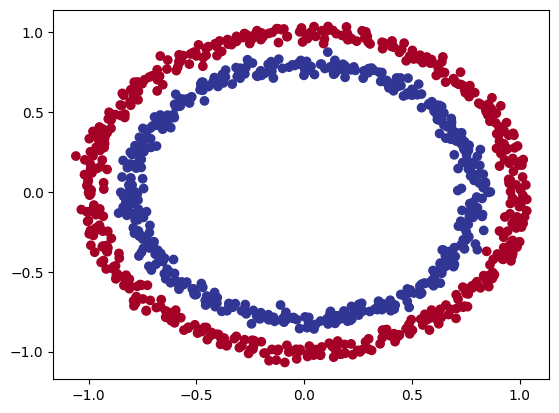

In [20]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [21]:
#checking input and output shape
X.shape,y.shape

((1000, 2), (1000,))

In [22]:
X_sample=X[0]
y_sample=y[0]
print(f"Value of one sample of X = {X_sample} and the same for y = {y_sample}")
print(f"Shape of one sample of X = {X_sample.shape} and the same for y = {y_sample.shape}")

Value of one sample of X = [0.75424625 0.23148074] and the same for y = 1
Shape of one sample of X = (2,) and the same for y = ()


#### converting data in tensors and creating train and test splits

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [26]:
#turning to tensors
import torch
X= torch.from_numpy(X).type(torch.float)
y= torch.from_numpy(y).type(torch.float)

In [27]:
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [28]:
#spliting data into train and test sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,
                                               y,
                                               test_size=0.2,
                                               random_state=42
                                            )

len(X_train),len(y_train),len(X_test),len(y_test)

(800, 800, 200, 200)

#### Building a model


In [29]:
from torch import nn
#deice agnostics code
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cpu'

In [30]:
# 1.creating a model that Subclass nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear() layer that are capable of handling the shape of our data
        self.layer_1=nn.Linear(in_features=2,out_features=5)
        self.layer_2=nn.Linear(in_features=5,out_features=1)

    # 3.Defines a forward method() that outlines the forward pass of the model
    def forward(self,x):
        return self.layer_2(self.layer_1(x)) # x-> layer_1-> layer_2 ->output


model_0=CircleModelV0()
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [31]:
# We can replicate the above model using nn.Sequential()
model_0=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [32]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [33]:
#making predictions
with torch.inference_mode():
    untrained_preds= model_0(X_test)
print(f"Lenght of predictions : {len(untrained_preds)} , Shape: {untrained_preds.shape}")
print(f"Lenght of test sample : {len(X_test)} , Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Lenght of predictions : 200 , Shape: torch.Size([200, 1])
Lenght of test sample : 200 , Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]])

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [34]:
# setting up loss function
loss_fn= nn.BCEWithLogitsLoss() #BCEWithLogitsLossk has a built-in sigmoid activation function

optimizer=torch.optim.SGD(params=model_0.parameters(),
                          lr=0.1)

In [35]:
# calculating the accuracy
# Acuracy is what percentage our model get right
def accuracy_fn(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc= (correct/len(y_pred))*100
    return acc

Training a model

In [36]:
# viewing logits
model_0.eval()
with torch.inference_mode():
    y_logits= model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [37]:
#using sigmoid activation function on our model logits

y_preds_probs=torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

In [38]:
torch.round(y_preds_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]])

In [39]:
#finding the prediction labels
y_preds= torch.round(y_preds_probs)

# In full (logits -> preds probs -> pred labels)
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test)))[:5]

#check for equality
print(torch.eq(y_preds.squeeze() , y_preds_labels.squeeze()))

#get rid of extra dimension
y_preds.squeeze()



tensor([True, True, True, True, True])


tensor([0., 0., 1., 0., 1.])

In [40]:
torch.manual_seed(42)

#set the number of epochs

epochs=100
# putting data to target device if gpu is available



""" little jingle to learn steps for training loop
    for epoch in range
    do model.train
    do the forwrd pass
    calculate the loss
    optimizer zero grad
    loss backwards
    optimise the step
"""
for epoch in range(epochs):
    # train
    model_0.train()

    # forward pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # calculate the loss
    loss = loss_fn(y_logits,
                   y_train)

    acc=accuracy_fn(y_true=y_train, #nn.BCEWithLogitsLoss expect raw logits as input
                    y_pred=y_preds)

    # optimizes the zero grad
    optimizer.zero_grad()
    # loss backwards
    loss.backward()
    # optimize the step
    optimizer.step()



    # testing
    model_0.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits=model_0(X_test).squeeze()
        test_pred= torch.round(torch.sigmoid(test_logits))
        # 2. calculate the loss
        test_loss= loss_fn(test_logits,
                        y_test)

        test_acc= accuracy_fn(y_true=y_test,
                            y_pred=test_pred)

        # print ehats happening
        if epoch % 10 == 0:
            print(f"Epoch : {epoch} | Loss : {loss:.5f} | Acc : {acc:.2f}% | Test Loss :{test_loss:.5f} | Test acc : {test_acc:.2f}%")

Epoch : 0 | Loss : 0.69796 | Acc : 51.88% | Test Loss :0.69440 | Test acc : 58.00%
Epoch : 10 | Loss : 0.69590 | Acc : 51.25% | Test Loss :0.69305 | Test acc : 53.00%
Epoch : 20 | Loss : 0.69490 | Acc : 51.62% | Test Loss :0.69254 | Test acc : 49.50%
Epoch : 30 | Loss : 0.69435 | Acc : 51.12% | Test Loss :0.69236 | Test acc : 49.50%
Epoch : 40 | Loss : 0.69401 | Acc : 50.88% | Test Loss :0.69232 | Test acc : 51.00%
Epoch : 50 | Loss : 0.69378 | Acc : 50.25% | Test Loss :0.69234 | Test acc : 50.00%
Epoch : 60 | Loss : 0.69362 | Acc : 50.00% | Test Loss :0.69239 | Test acc : 51.50%
Epoch : 70 | Loss : 0.69351 | Acc : 50.25% | Test Loss :0.69246 | Test acc : 51.00%
Epoch : 80 | Loss : 0.69342 | Acc : 49.88% | Test Loss :0.69254 | Test acc : 50.00%


Epoch : 90 | Loss : 0.69336 | Acc : 49.88% | Test Loss :0.69262 | Test acc : 53.00%


In [ ]:
import requests
from pathlib import Path

#download helper function from Learn PyTorch repo(if it's not downloaded)
if Path("helper_functions.py").is_file():
    print("Helper function already exists skipping download")

else:
    print("Downloading helper_function.py")
    # request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

    # from helper_functions import plot_predictions, plot_decision_boundary

ModuleNotFoundError: No module named 'requests'

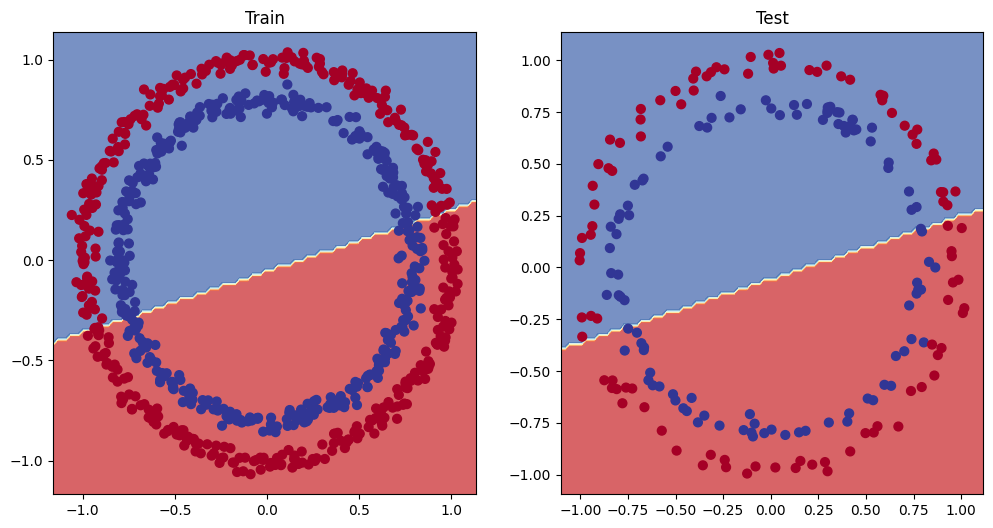

In [ ]:
# plot prediction boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test, y_test)


### Imporving our model
- Adding more layers
- Add more hidden layers
- Fit for longer
- changing the learning rate
- change the loss function

These options are all from the model's perspective beacuse they deal directly with the model rather than data

We can change the **hyperparamteres**

In [42]:

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1= nn.Linear(in_features=2,out_features=10)
        self.layer_2=nn.Linear(in_features=10,out_features=10)
        self.layer_3=nn.Linear(in_features=10,out_features=1)
    
    def forward(self,x):
        # z=self.layer_1(x)
        # z=self.layer_2(z)
        # z=self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1=CircleModelV1()    

Adding loss function and optimizer

In [43]:
import torch
# creating a loss function
loss_fn=nn.BCEWithLogitsLoss()

# Creating an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [44]:
# writing training and testing loop
torch.manual_seed(42)

epochs =1000

# put data in target device 
"""pytorch song
for epoch in range
do the forward pass
calculate the loss
optimize the zero grad
loss backward
optimizer step"""
for epoch in range(epochs):
    #training 
    model_1.train()
    
    # 1. forward passs
    y_logits= model_1(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_preds))
    
    # 2. calculate the loss
    
    loss=loss_fn(y_logits,y_train)
    acc= accuracy_fn(y_true=y_train,
                     y_pred=y_pred)
    
    # 3. optimizer zero grad
    optimizer.zero_grad()
    
    # 4. loss backwards
    loss.backward()
    
    # optimizer step
    optimizer.step()
    
    #testing
    
    model_1.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits =model_1(X_test).squeeze()
        tese_preds=torch.round(torch.sigmoid(test_logits))
        # 2. calculate the loss
        test_loss=loss_fn(test_logits,
                          y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print what's happenin'
    if epoch %100 == 0:
        print(f"Epoch : {epoch} | Loss : {loss:.5f} | Acc : {acc:.2f}% | Test Loss :{test_loss:.5f} | Test acc : {test_acc:.2f}%")

Epoch : 0 | Loss : 0.69396 | Acc : 49.38% | Test Loss :0.69261 | Test acc : 53.00%
Epoch : 100 | Loss : 0.69305 | Acc : 49.38% | Test Loss :0.69379 | Test acc : 53.00%
Epoch : 200 | Loss : 0.69299 | Acc : 49.38% | Test Loss :0.69437 | Test acc : 53.00%
Epoch : 300 | Loss : 0.69298 | Acc : 49.38% | Test Loss :0.69458 | Test acc : 53.00%
Epoch : 400 | Loss : 0.69298 | Acc : 49.38% | Test Loss :0.69465 | Test acc : 53.00%
Epoch : 500 | Loss : 0.69298 | Acc : 49.38% | Test Loss :0.69467 | Test acc : 53.00%
Epoch : 600 | Loss : 0.69298 | Acc : 49.38% | Test Loss :0.69468 | Test acc : 53.00%
Epoch : 700 | Loss : 0.69298 | Acc : 49.38% | Test Loss :0.69468 | Test acc : 53.00%
Epoch : 800 | Loss : 0.69298 | Acc : 49.38% | Test Loss :0.69468 | Test acc : 53.00%
Epoch : 900 | Loss : 0.69298 | Acc : 49.38% | Test Loss :0.69468 | Test acc : 53.00%


In [ ]:
# plot prediction boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test, y_test)
